In [55]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml
from sklearn.preprocessing import LabelEncoder, StandardScaler
import seaborn as sns

In [56]:
import warnings
from sklearn.exceptions import ConvergenceWarning

warnings.filterwarnings("ignore", category=ConvergenceWarning)
warnings.filterwarnings("ignore", category=UserWarning)

In [57]:
# housing = fetch_openml(name='house_prices', as_frame=True)
housing = fetch_openml(name='boston', as_frame=True)
df = housing.frame

df.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222.0,18.7,396.90,5.33,36.2


In [58]:
categorical_cols = df.select_dtypes(include=['object']).columns
for col in categorical_cols: 
    le = LabelEncoder() 
    df[col] = le.fit_transform(df[col]) 
    df = df.drop(columns=df.nunique()[df.nunique() < 4].index) 


scaler = StandardScaler()  
df = pd.DataFrame(scaler.fit_transform(df), columns=df.columns)

df.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,-0.419782,0.284830,-1.287909,-0.272599,-0.144217,0.413672,-0.120013,0.140214,-0.982843,-0.666608,-1.459000,0.441052,-1.075562,0.159686
1,-0.417339,-0.487722,-0.593381,-0.272599,-0.740262,0.194274,0.367166,0.557160,-0.867883,-0.987329,-0.303094,0.441052,-0.492439,-0.101524
2,-0.417342,-0.487722,-0.593381,-0.272599,-0.740262,1.282714,-0.265812,0.557160,-0.867883,-0.987329,-0.303094,0.396427,-1.208727,1.324247
3,-0.416750,-0.487722,-1.306878,-0.272599,-0.835284,1.016303,-0.809889,1.077737,-0.752922,-1.106115,0.113032,0.416163,-1.361517,1.182758
4,-0.412482,-0.487722,-1.306878,-0.272599,-0.835284,1.228577,-0.511180,1.077737,-0.752922,-1.106115,0.113032,0.441052,-1.026501,1.487503


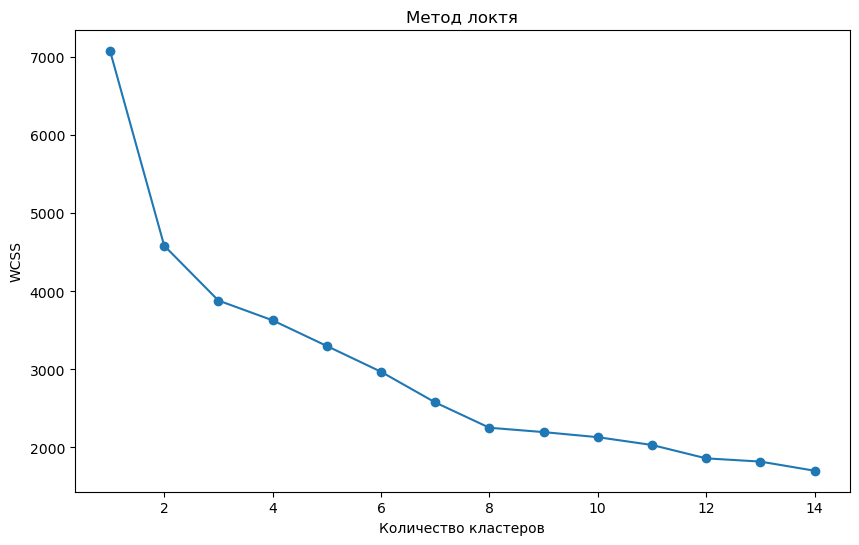

In [59]:
from sklearn.cluster import KMeans

wcss = []
for i in range(1, 15):
    kmeans = KMeans(n_clusters=i, random_state=42)
    kmeans.fit(df)
    wcss.append(kmeans.inertia_)

plt.figure(figsize=(10, 6))
plt.plot(range(1, 15), wcss, marker='o')
plt.title('Метод локтя')
plt.xlabel('Количество кластеров')
plt.ylabel('WCSS')
plt.show()


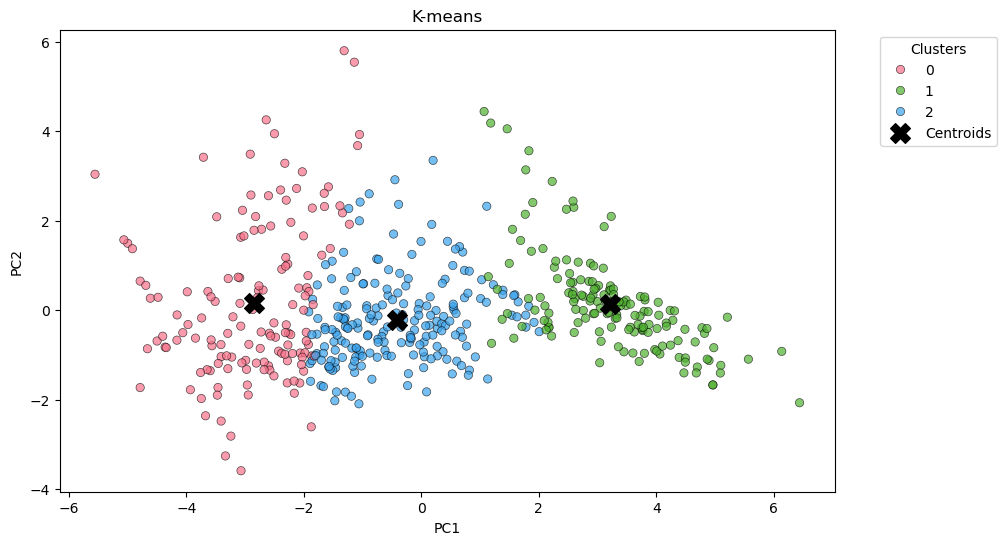

In [60]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
df_pca = pd.DataFrame(pca.fit_transform(df), columns=['PC1', 'PC2'])

optimal_clusters = 3
kmeans = KMeans(n_clusters=optimal_clusters, random_state=42)
clusters = kmeans.fit_predict(df)
kmeans_labels = kmeans.fit_predict(df)

centroids_pca = pca.transform(kmeans.cluster_centers_)

plt.figure(figsize=(10, 6))
scatter = sns.scatterplot(
    x=df_pca['PC1'], 
    y=df_pca['PC2'], 
    hue=clusters, 
    palette=sns.color_palette("husl", n_colors=optimal_clusters),
    edgecolor='k',
    alpha=0.7
)

plt.scatter(
    x=centroids_pca[:, 0], 
    y=centroids_pca[:, 1], 
    marker='X',
    s=200,
    c='black',  
    label='Centroids',
    edgecolor='k',
    linewidth=1
)

plt.title('K-means')
plt.legend(bbox_to_anchor=(1.05, 1), title='Clusters', loc='upper left')
plt.show()

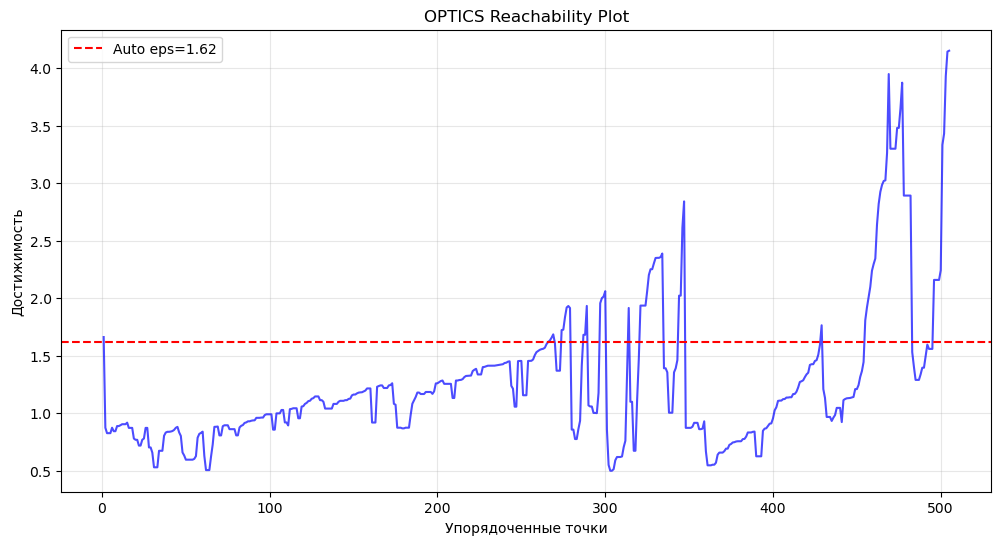

In [61]:
from sklearn.cluster import OPTICS, DBSCAN

optics = OPTICS(min_samples=5, xi=0.05)
optics.fit(df)

plt.figure(figsize=(12, 6))
plt.plot(optics.reachability_[optics.ordering_], color='blue', alpha=0.7)
plt.title('OPTICS Reachability Plot')
plt.xlabel('Упорядоченные точки')
plt.ylabel('Достижимость')
plt.grid(True, alpha=0.3)

eps = np.quantile(optics.reachability_[optics.ordering_], 0.85)
plt.axhline(y=eps, color='red', linestyle='--', label=f'Auto eps={eps:.2f}')
plt.legend()
plt.show()

Найдено кластеров: 4
Точек шума: 133


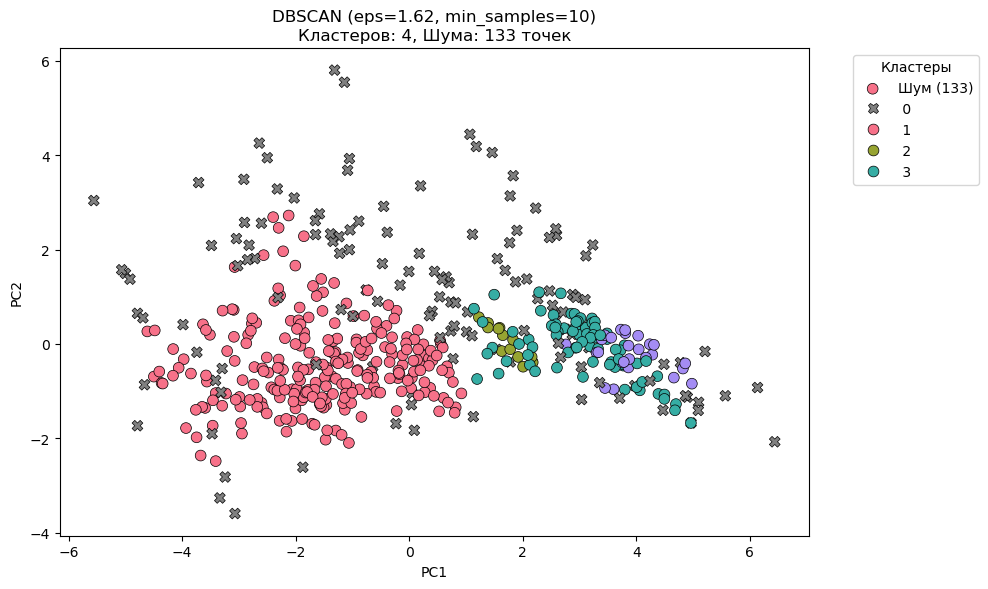

In [62]:

pca = PCA(n_components=2)
df_pca = pd.DataFrame(pca.fit_transform(df), columns=['PC1', 'PC2'])

eps = 1.62      
min_samples = 10

dbscan = DBSCAN(eps=eps, min_samples=min_samples)
clusters = dbscan.fit_predict(df)
dbscan_labels = dbscan.fit_predict(df)

n_clusters = len(set(clusters)) - (1 if -1 in clusters else 0)
n_noise = list(clusters).count(-1)
print(f"Найдено кластеров: {n_clusters}")
print(f"Точек шума: {n_noise}")

plt.figure(figsize=(10, 6))

palette = sns.color_palette("husl", n_colors=n_clusters)
if -1 in clusters:
    palette = ['gray'] + palette 

sns.scatterplot(
    x=df_pca['PC1'], 
    y=df_pca['PC2'], 
    hue=clusters, 
    palette=palette,
    style=clusters,
    markers={-1: 'X', **{i: 'o' for i in range(n_clusters)}},
    s=60,
    edgecolor='k',
    linewidth=0.5
)

plt.title(f'DBSCAN (eps={eps}, min_samples={min_samples})\n'
          f'Кластеров: {n_clusters}, Шума: {n_noise} точек')
plt.legend(
    bbox_to_anchor=(1.05, 1), 
    loc='upper left',
    title='Кластеры',
    labels=[f'Шум ({n_noise})'] + [f' {i}' for i in range(n_clusters)]
)
plt.tight_layout()
plt.show()

In [63]:
from sklearn.metrics import silhouette_score, davies_bouldin_score

print("K-means:")
print(f"Silhouette Score: {silhouette_score(df, kmeans_labels):.3f}") 
print(f"Davies-Bouldin Index: {davies_bouldin_score(df, kmeans_labels):.3f}")

print("\nDBSCAN:")
print(f"Silhouette Score: {silhouette_score(df, dbscan_labels):.3f}")
print(f"Davies-Bouldin Index: {davies_bouldin_score(df, dbscan_labels):.3f}")

K-means:
Silhouette Score: 0.234
Davies-Bouldin Index: 1.472

DBSCAN:
Silhouette Score: 0.158
Davies-Bouldin Index: 1.983
